# Customers Segmentation

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA


## Data

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

For segmentation I am considering users from prior set only

In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [4]:
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21.0


In [5]:
order_products.user_id.nunique()

206209

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [6]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,3,0,1,0,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,0,1,1,0,0,0,0,1,5,0,2,0,0,0,1,11,0,0,0,0,2,0,1,16,0,0,0,2,0,0,0,13,7,0,0,0,0,2,0,0,7,7,0,14,3,0,6,0,0,4,0,5,3,0,0,0,0,0,0,0,2,55,0,0,1,5,0,0,0,1,5,0,0,0,0,0,0,0,18,0,0,1,2,3,0,0,0,0,6,3,0,0,5,0,0,0,0,1,0,0,19,0,2,0,0,0,8,8,7,1,3,0,3,0,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,1,8,0,0,0,0,5,0,5,0,0,0,0,0,0,2,1,4,6,0,0,0,0,0,0,2,17,0,0,18,0,0,1,0,0,0,2,1,9,7,1,1,0,0,0,3,3,1,0,0,0,2,0,0,1,0,6,0,1,18,0,0,0,0,2,1,0,0,1,14,2,0,0,0,15,0,6,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,4,0,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,0,55,0,0,0,0,0,22,2,0,3,6,0,0,13,12,0,0,7,0,6,0,2,16,0,0,0,4,0,5,2,23,35,1,0,0,0,0,0,1,55,23,1,45,0,1,3,0,0,2,0,2,16,0,8,1,2,0,2,2,11,2,0,0,11,2,0,0,0,0,27,2,0,28,0,2,0,0,0,6,0,0,4,11,1,4,3,5,71,0,2,0,2,0,1,0,0,0,0,0,10,0,1,0,0,0,5,0,2,24,0,0,7,0,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,1,0,0,5,2,0,0,6,1,1,0,0,0,0,1,4,0,0,0,0,2,0,0,1,2,3,0,0,0,0,0,1,4,13,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,8,2,0,0,6,0,0,0,0,2,2,0,0,2,5,0,1,0,0,5,1,2,1,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,10,0,9,0,0,1,0,0,0,0,0,0,1,0,0,0,3


 normalizing each row

In [8]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

This table is helpful for understanding the distribution of each user’s shopping behavior across different aisles.

In [9]:
df.shape

(206209, 134)

### PCA and K-Means Clustering

Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [10]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088341,-0.104549,-0.116443,0.083694,-0.062523,-0.026177
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033960,-0.054736,-0.053366,-0.020370,-0.008092
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112238,-0.029812,0.007860,0.012277,0.001852
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019278,-0.025115,-0.038234,0.006492,-0.000623
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107649,-0.008034,0.103931,0.051732,-0.025799


This code performs the "Elbow Method" for determining the optimal number of clusters in a dataset after dimensionality reduction, likely with PCA

In [11]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

This list will store the sum of squared distances (or "inertia") for each k value, which measures how well the clusters are compacted for each number of clusters. Lower inertia values indicate more compact clusters.


In [12]:
Sum_of_squared_distances

[9034.72128031578,
 7469.689722195839,
 6629.2253025576065,
 5935.021671890524,
 5393.4431242944465,
 5116.991308356824,
 4718.983320032643,
 4463.61444990669,
 4238.688921342186]

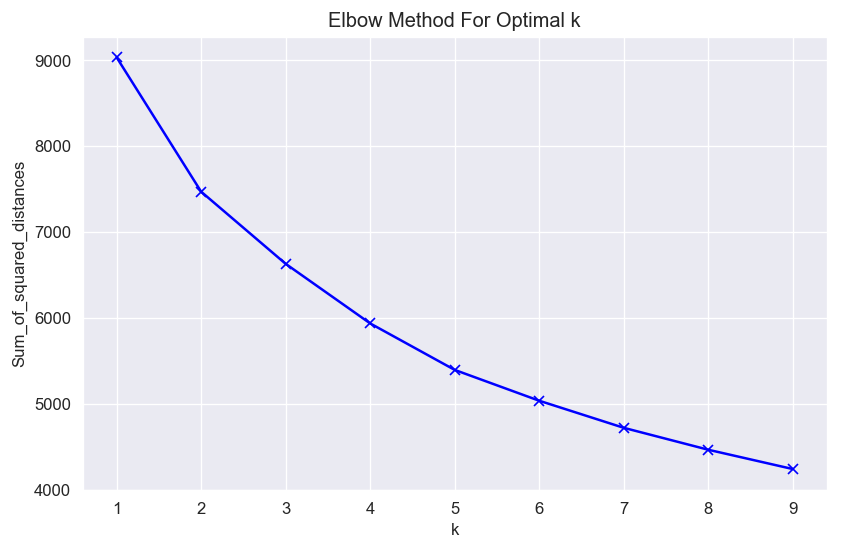

In [44]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 7

In [14]:
clusterer = KMeans(n_clusters=7,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 0.14497848 -0.09512519  0.02963077  0.00887472  0.00119666 -0.01519968
  -0.0012653   0.00069315  0.00163379  0.00187392]
 [-0.10018527 -0.01182106 -0.025748    0.00572819 -0.02678522 -0.00366655
   0.00288453 -0.0035713   0.00078146 -0.00050846]
 [-0.20444494  0.01659789  0.33871821 -0.03181279  0.01972732  0.00357759
   0.00735006  0.00975926  0.00103828 -0.00477376]
 [-0.04550912  0.02212533 -0.04765212 -0.09411086  0.10987323 -0.02053859
  -0.02401235  0.00060053  0.00271831  0.00152373]
 [ 0.1072032   0.17994779  0.01259728 -0.02501303 -0.03309691 -0.00330294
   0.00134936  0.00162685  0.00081842 -0.00076657]
 [ 0.02703566 -0.00464787 -0.00677143 -0.00776675 -0.00539213  0.01796116
   0.00208422  0.00252755 -0.00322101 -0.00059818]
 [-0.01193868  0.12315126  0.00429133  0.23419905  0.11330706 -0.02223645
   0.00089006 -0.00610375  0.00786232  0.00339123]]


#### Visualizing clustering among first two principal components

In [15]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

C:\Users\abhis\AppData\Local\Temp\ipykernel_53284\1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,1
1,-0.036988,0.108884,3
2,0.064282,0.103962,4
3,-0.093210,0.054093,1
4,0.094629,-0.037051,5


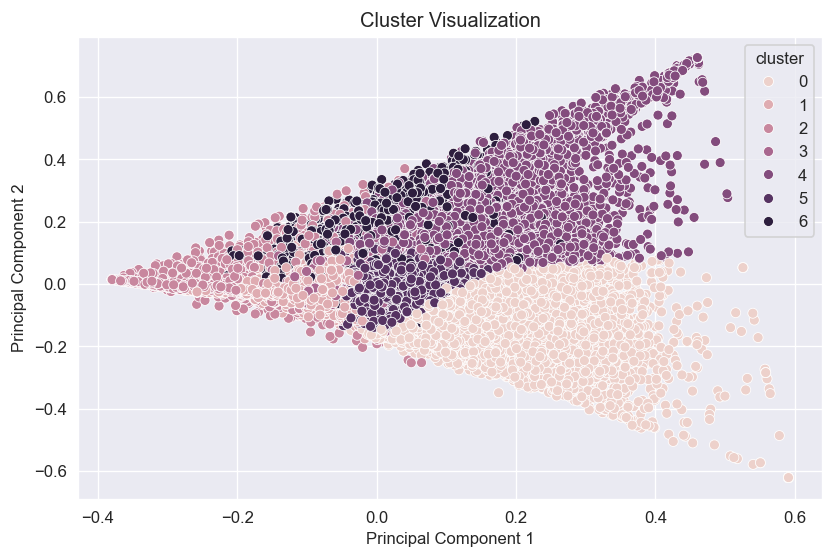

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2",hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [19]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [20]:
cluster1.shape

(32090, 135)

In [21]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 40.809286
fresh fruits                     20.956279
packaged vegetables fruits       10.750078
yogurt                            4.734871
fresh herbs                       4.450452
packaged cheese                   3.829854
milk                              3.234653
soy lactosefree                   3.183484
frozen produce                    2.870427
water seltzer sparkling water     2.551823
dtype: float64

In [22]:
cluster2.shape

(63833, 135)

In [23]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     5.852114
chips pretzels                   4.349568
packaged cheese                  3.928391
water seltzer sparkling water    3.925039
fresh vegetables                 3.744427
packaged vegetables fruits       3.587126
milk                             3.442201
yogurt                           3.337161
soft drinks                      3.321511
ice cream ice                    3.055363
dtype: float64

In [24]:
cluster3.shape

(4788, 135)

In [25]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.894946
fresh fruits                      3.072473
soft drinks                       2.594403
yogurt                            1.447368
energy granola bars               1.415622
chips pretzels                    1.208647
milk                              1.195906
tea                               1.177945
packaged vegetables fruits        1.144737
soy lactosefree                   0.994152
dtype: float64

In [26]:
cluster4.shape

(14483, 135)

In [27]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
yogurt                           30.339501
fresh fruits                     16.493337
fresh vegetables                  7.680522
packaged vegetables fruits        6.945039
milk                              6.196851
packaged cheese                   4.908030
water seltzer sparkling water     4.531658
energy granola bars               3.945937
chips pretzels                    3.708417
refrigerated                      3.670510
dtype: float64

In [28]:
cluster5.shape

(15395, 135)

In [29]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     34.304709
fresh vegetables                  8.975057
packaged vegetables fruits        8.092433
yogurt                            4.629360
milk                              4.069958
water seltzer sparkling water     2.627996
packaged cheese                   2.612537
soy lactosefree                   2.610458
chips pretzels                    1.973303
packaged produce                  1.858396
dtype: float64

Customer Segmentation Results:

- Cluster 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
- Cluster 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
- Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
- Cluster 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
- Cluster 5 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet. 